**Task:** To train a model that can classify songs into correct genres. 

**Data:** Dataset of songs, compiled by a research group known as The Echo Nest. It contains variuos features of songs like acoustincness, tempo etc. for each song along with a label for its genre - either Hip Hop or Rock.
Thus its a binary classification prblem.

**Approach:**

- Pre-processing data
- Exploring features
- Training different classification Models (both single models and ensemble models)
- Tuning model for higher accuracy/AUC score (using RandomizedsearchCV and GridsearchCV)
- Summarizing results 

I have used the cross-validation scores (with 5 folds i.e 20% test set) to compare and choose the final model. 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Data Preprocessing

In [3]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)

In [4]:
tracks.head(2)

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky


In [5]:
echonest_metrics.head(1)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.15931,165.922,0.576661


tracks table contains the genre label w.r.t the track id and  echonest_metrics table contains all the features w.r.t to the track id. Lets **merge both datasets** to get our final data set.

In [6]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(left=echonest_metrics, right=tracks[['track_id', 'genre_top']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


**There are no missing values in the data set and all features are numeric.**

In [7]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


## Distribution of Classes

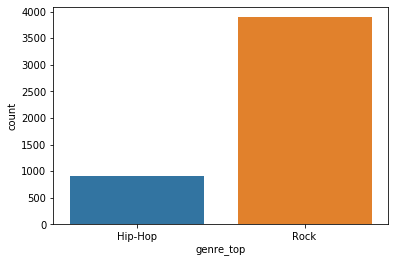

In [8]:
sns.countplot(echo_tracks['genre_top'])

In [9]:
echo_tracks.genre_top.value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

In [10]:
echo_tracks.genre_top.value_counts(normalize=True).mul(100)

Rock       81.049563
Hip-Hop    18.950437
Name: genre_top, dtype: float64

**This is a case of Imbalanced classes as the minority class is only 19% of the dataset. 
If a classifier predicts all classes as Rock, it will still have 81% accuracy. Thus a meaningful classifier should perform much better than that.**

## Correlation Heat map

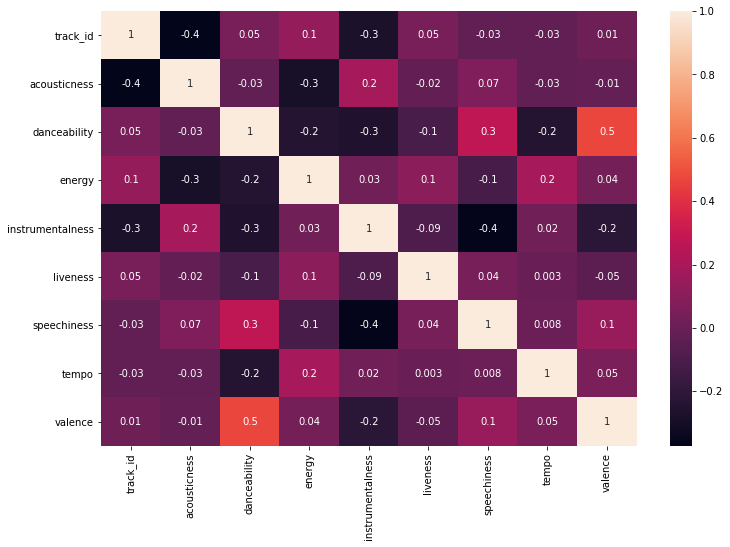

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(echo_tracks.corr(), annot = True, fmt='.1g')

**They are no strongly correlated features here. Hence we will include all the features while training for now.** 

# Feature Summary

comparing means value of the features for both genres. 

In [12]:
a = echo_tracks.drop(columns = ['track_id'])
a.groupby('genre_top').aggregate(['mean']).T.style.background_gradient(cmap='Blues', axis= 1)

,genre_top,Hip-Hop,Rock
acousticness,mean,0.412649,0.504458
danceability,mean,0.620385,0.393574
energy,mean,0.562114,0.639859
instrumentalness,mean,0.350269,0.663444
liveness,mean,0.190199,0.187483
speechiness,mean,0.254705,0.0698455
tempo,mean,118.632,128.571
valence,mean,0.589433,0.42161


## Visualizing Feature Distributions

Goal
- identify most distinctive features
- checks for any extreme outliers

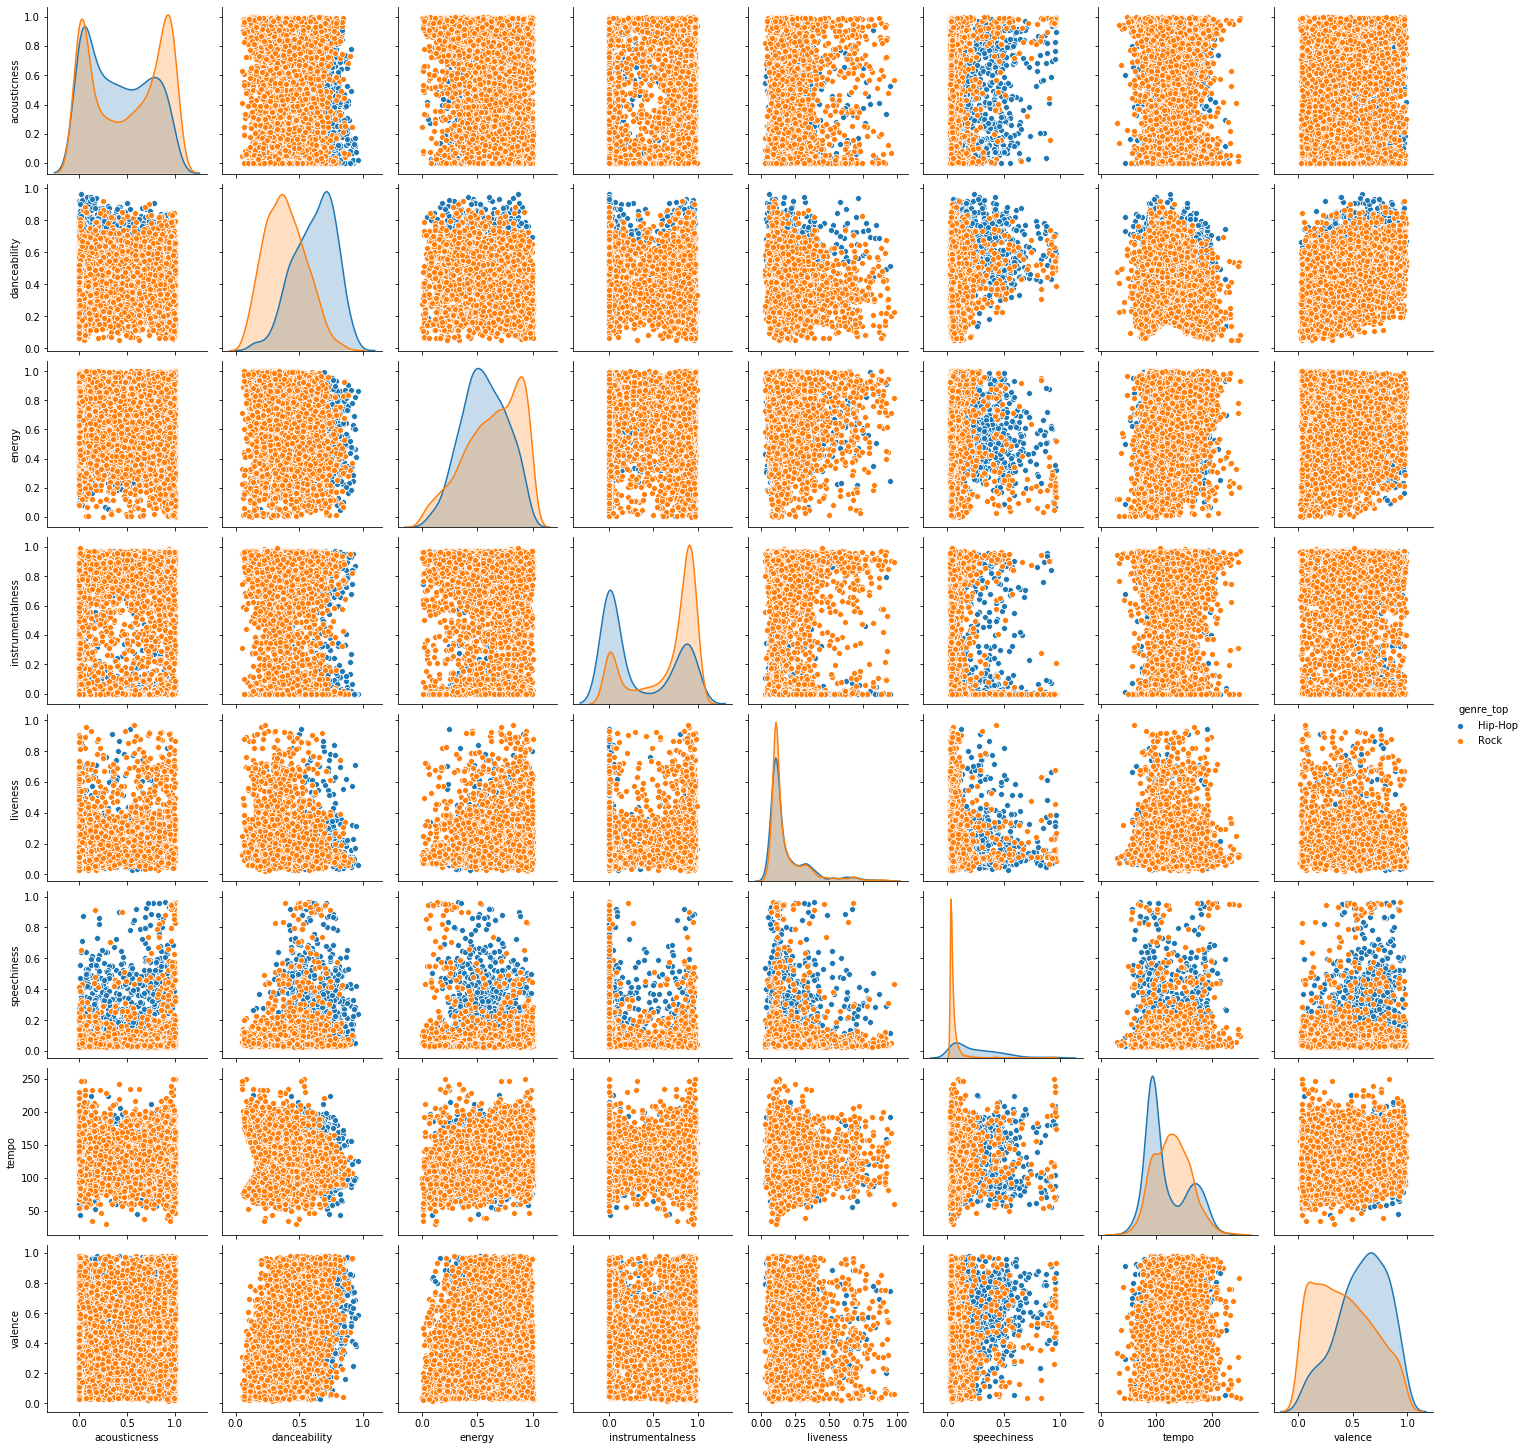

In [59]:
a = echo_tracks.drop(columns = ['track_id'])
sns.pairplot(a, hue = 'genre_top')

#### Observations

- No major outliers
- Apart from danceability, all other features are significantly overlapping for both genres.
- Speechiness also shows a distinguishable behaviour for both genres. 

# Scaling Data

Splitting Features and the target label

In [61]:
echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop', 'label'] = 1
echo_tracks.loc[echo_tracks['genre_top'] != 'Hip-Hop', 'label'] = 0
y = echo_tracks['label']  #Target label
X = echo_tracks.drop(columns = ['genre_top', 'label', 'track_id'])   #Feature set

Scaling the feature set

In [30]:
#Using sklearn
from sklearn  import preprocessing
X_std =  pd.DataFrame(preprocessing.scale(X), columns = X.columns)

In [31]:
X_std.head(4)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,-0.191210,1.304420,0.038316,-1.576494,-0.068755,0.373034,1.153979,0.462287
1,-0.306036,0.501886,0.788176,-1.599809,-0.545463,2.446155,0.007914,-0.690811
2,-1.204813,1.684139,0.312852,-1.602876,1.229828,0.135130,-0.777317,0.631077
3,-0.094655,0.417927,-0.265203,-1.553079,-0.607326,2.882707,-0.364657,1.652859


In [63]:
#using apply function
X_std = X.apply(lambda x: (x-x.mean())/x.std(), axis=0)

# Training Different Models

Since the dataset is small in size, we will take 20% of the data as our test set. Thus using stratified folds = 5 to obtain a cross validation test score. We have used Stratified split to ensure the test set has same proportion of both classes as the train set. 

Approach:
Training and comparing different classifiers with default settings, we will then choose the top ones to further tune their hyperparameters.

In [32]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [33]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_validate

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis()]


#Possible scoring metrics : ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']

# Logging for Visual Comparison
log_cols = ['Name','CV Train Accuracy', 'CV Test Accuracy', 'CV Train AUC', 'CV Test AUC','Time_taken_secs']
splits = 5
scv = StratifiedKFold(n_splits= splits)
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    
    t_start = time.clock()
    model_output = cross_validate(clf, X, y, scoring=['accuracy','roc_auc'], cv=scv, return_train_score = True)
    t_end = time.clock()
    t_diff = t_end - t_start
    
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')  
    train_accuracy = model_output['train_accuracy'].mean()
    test_accuracy =  model_output['test_accuracy'].mean()
    train_roc_auc = model_output['train_roc_auc'].mean()
    test_roc_auc = model_output['test_roc_auc'].mean()                                                                                                         
    print("CV Test accuracy: {:.4%}".format(test_accuracy))
    print("CV test roc_auc score: {:.4}".format(test_roc_auc))

    
    log_entry = pd.DataFrame([[name, round(train_accuracy*100,3), round(test_accuracy*100,3), round(train_roc_auc,3), round(test_roc_auc,3), t_diff]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30) 

LogisticRegression
****Results****
CV Test accuracy: 87.7341%
CV test roc_auc score: 0.904
KNeighborsClassifier
****Results****
CV Test accuracy: 84.5897%
CV test roc_auc score: 0.7911
SVC
****Results****
CV Test accuracy: 81.0496%
CV test roc_auc score: 0.8227
DecisionTreeClassifier
****Results****
CV Test accuracy: 87.5676%
CV test roc_auc score: 0.8058
RandomForestClassifier
****Results****
CV Test accuracy: 91.5664%
CV test roc_auc score: 0.9482
AdaBoostClassifier
****Results****
CV Test accuracy: 91.0457%
CV test roc_auc score: 0.9411
GradientBoostingClassifier
****Results****
CV Test accuracy: 91.8996%
CV test roc_auc score: 0.9515
GaussianNB
****Results****
CV Test accuracy: 87.5465%
CV test roc_auc score: 0.9022
LinearDiscriminantAnalysis
****Results****
CV Test accuracy: 88.4840%
CV test roc_auc score: 0.912


In [34]:
log # Highlighting

,Name,CV Train Accuracy,CV Test Accuracy,CV Train AUC,CV Test AUC,Time_taken_secs
0,LogisticRegression,89.036,87.734,0.911,0.904,1.135289
0,KNeighborsClassifier,92.061,84.590,0.966,0.791,1.204350
0,SVC,81.050,81.050,0.844,0.823,4.420064
0,DecisionTreeClassifier,100.000,87.568,1.000,0.806,0.181600
0,RandomForestClassifier,99.990,91.566,1.000,0.948,3.190577
0,AdaBoostClassifier,92.425,91.046,0.967,0.941,1.451449
0,GradientBoostingClassifier,94.981,91.900,0.985,0.951,3.980428
0,GaussianNB,88.906,87.546,0.907,0.902,0.047930
0,LinearDiscriminantAnalysis,89.359,88.484,0.918,0.912,0.334324


##### Observtions

- Both Random Forest and Gradient Boosting have a high performance both in terms of accuracy and auc score
- Difference between train and test scores is much higher for Random Forest than Gradient Bosst, suggesting a possible case of overfitting. 
- Training time is very low for all models beacuse of comparatively small dataset. Thus its of least concern moving forward. 

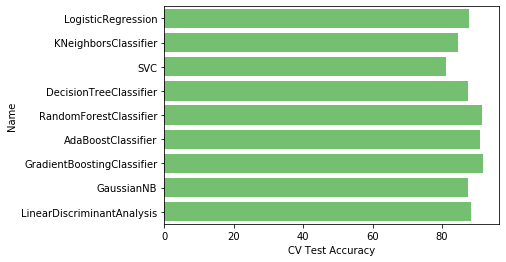

In [35]:
sns.set_color_codes("muted")
sns.barplot(x='CV Test Accuracy', y='Name', data=log, color="g")

# Tuning Classifiers

- Feature selection/PCA (purpose is same)   - plot feature importance - select Kbest if that improves
- Tuning basic hyper parameters - the arguments in the algorithm

- Trying if under/oversampling or SMOTE can help   --- last step keep it for the rare datasets like cancer

We will try tuning RandomForest as it is overfitted which we probably can reduce.

## Feature Importance

In [56]:
rf = RandomForestClassifier()
rf.fit(X,y)
rf.feature_importances_

array([0.08319216, 0.21422417, 0.07636751, 0.11249515, 0.04703302,
       0.28751462, 0.10259013, 0.07658324])

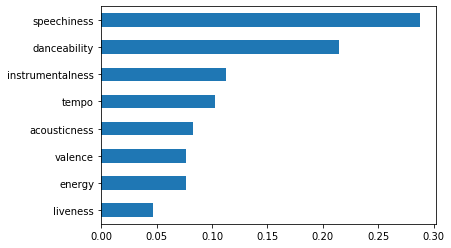

In [62]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nsmallest(X.shape[1]).plot(kind='barh')

### observations

- speechiness and danceability are two most important features in distinguishing between the genres. (we predicted that from pair plots as well)
- Rest of the features have almost equal importance. 

Since this dataset has small number of features, and there is none with extremely low importance it is highly unlikely that feature selection or PCA will give us a very significant improvement. For this workbook we will skip both feature selection and PCA for regularizing and keep it for future work. 

## Using Randomized Grid Search 

Current parameters

In [37]:
from pprint import pprint
rf = RandomForestClassifier()
pprint(rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>


In [39]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 100, None],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


Benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [40]:
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold Stratified cross validation, 
scv = StratifiedKFold(n_splits= 5)

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = scv, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_sp...
                   ii

In [41]:
rf_random.best_params_

{'n_estimators': 311,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

### Comparing tuned model

In [51]:
# Comparing naive randomforest classifier and that suggested by Random Search

random_search = rf_random.best_estimator_
rf_base = RandomForestClassifier(random_state=42)

classifiers = [random_search, rf_base]
clf_name = ['random_search_rf', 'rf_base']

#Comparing Performance

log_cols = ['Name','CV Train Accuracy', 'CV Test Accuracy', 'CV Train AUC', 'CV Test AUC','Time_taken_secs']
splits = 5
scv = StratifiedKFold(n_splits= splits)
log = pd.DataFrame(columns=log_cols)


for i, clf in enumerate(classifiers):
    
    t_start = time.clock()
    model_output = cross_validate(clf, X, y, scoring=['accuracy','roc_auc'], cv=scv, return_train_score = True)
    t_end = time.clock()
    t_diff = t_end - t_start
    
    name = clf_name[i]
    
    print("="*30)
    print(name)
    
    print('****Results****')  
    train_accuracy = model_output['train_accuracy'].mean()
    test_accuracy =  model_output['test_accuracy'].mean()
    train_roc_auc = model_output['train_roc_auc'].mean()
    test_roc_auc = model_output['test_roc_auc'].mean()                                                                                                         
    print("CV Test accuracy: {:.4%}".format(test_accuracy))
    print("CV test roc_auc score: {:.4}".format(test_roc_auc))

    
    log_entry = pd.DataFrame([[name, round(train_accuracy*100,3), round(test_accuracy*100,3), round(train_roc_auc,3), round(test_roc_auc,3), t_diff]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30) 

random_search_rf
****Results****
CV Test accuracy: 91.9204%
CV test roc_auc score: 0.951
rf_base
****Results****
CV Test accuracy: 91.7122%
CV test roc_auc score: 0.9481


In [52]:
log

,Name,CV Train Accuracy,CV Test Accuracy,CV Train AUC,CV Test AUC,Time_taken_secs
0,random_search_rf,96.418,91.920,0.994,0.951,8.654606
0,rf_base,100.000,91.712,1.000,0.948,3.082886


We have reduced overfitting and gained an accuracy of **0.2%** Yay!!

## Narrowing down parameters with GridSearch

In [79]:
rf = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 95, 100, 105,110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5, 6],
    'max_features': ['sqrt'],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 311, 320]
}
# Create a based model

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = scv, n_jobs = -1, verbose = 1)

grid_search.fit(X,y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [80]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 320}

### Comparing Preformance

In [81]:
# Comparing naive randomforest classifier and that suggested by Random Search

random_search = rf_random.best_estimator_
rf_base = RandomForestClassifier(random_state=42)
grid_srch = grid_search.best_estimator_

classifiers = [ rf_base, random_search, grid_srch]
clf_name = ['rf_base', 'random_search_rf', 'grid_search']

#Comparing Performance

log_cols = ['Name','CV Train Accuracy', 'CV Test Accuracy', 'CV Train AUC', 'CV Test AUC','Time_taken_secs']
splits = 5
scv = StratifiedKFold(n_splits= splits)
log = pd.DataFrame(columns=log_cols)


for i, clf in enumerate(classifiers):
    
    t_start = time.clock()
    model_output = cross_validate(clf, X, y, scoring=['accuracy','roc_auc'], cv=scv, return_train_score = True)
    t_end = time.clock()
    t_diff = t_end - t_start
    
    name = clf_name[i]
    
    print("="*30)
    print(name)
    
    print('****Results****')  
    train_accuracy = model_output['train_accuracy'].mean()
    test_accuracy =  model_output['test_accuracy'].mean()
    train_roc_auc = model_output['train_roc_auc'].mean()
    test_roc_auc = model_output['test_roc_auc'].mean()                                                                                                         
    print("CV Test accuracy: {:.4%}".format(test_accuracy))
    print("CV test roc_auc score: {:.4}".format(test_roc_auc))

    
    log_entry = pd.DataFrame([[name, round(train_accuracy*100,3), round(test_accuracy*100,3), round(train_roc_auc,3), round(test_roc_auc,3), t_diff]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30) 

rf_base
****Results****
CV Test accuracy: 91.7122%
CV test roc_auc score: 0.9481
random_search_rf
****Results****
CV Test accuracy: 91.9621%
CV test roc_auc score: 0.9512
grid_search
****Results****
CV Test accuracy: 92.0662%
CV test roc_auc score: 0.9504


In [82]:
log

,Name,CV Train Accuracy,CV Test Accuracy,CV Train AUC,CV Test AUC,Time_taken_secs
0,rf_base,100.000,91.712,1.000,0.948,3.008064
0,random_search_rf,96.449,91.962,0.994,0.951,8.482145
0,grid_search,96.423,92.066,0.994,0.950,8.697871


We have increased the accuracy a little more to 92% now

## Classification Results

In [97]:
from sklearn.metrics import classification_report

# splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)
                                                    

## Predict using the best estimator
model = grid_srch.fit(X_train,y_train)
predicted = grid_srch.predict(X_test)

print("Logistic Regression: \n",classification_report(y_test, predicted, target_names = ['Rock','Hip-Hop']))

Logistic Regression: 
               precision    recall  f1-score   support

        Rock       0.93      0.98      0.95       779
     Hip-Hop       0.87      0.68      0.76       182

    accuracy                           0.92       961
   macro avg       0.90      0.83      0.86       961
weighted avg       0.92      0.92      0.92       961



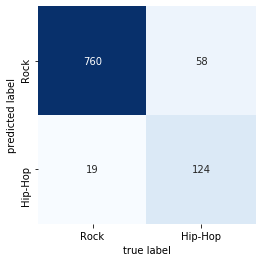

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues,
            xticklabels=['Rock','Hip-Hop'],
            yticklabels=['Rock','Hip-Hop'])
plt.xlabel('true label')
plt.ylabel('predicted label');

# Conclusion

- Since its an imbalanced data set, a naive classifier has an accuracy of 81%. 
- Popular non ensembles classifiers like Logistic regression, decision tree, SVM, KNN are not able to perform well with maximum accuracy of 87%. 
- Ensemble methods like RandomForest and Gradient Boost give the best results with accuracy upto 91.7%
- We were able to improve the Random Forest from 91.7% accuracy to 92% via hypereparameter tuning.

# What more Can be done

 1. Explore feature selection, PCA methods to see if that reduces overfitting and improves the cross validation score. 
 2. Explore methods to deal with Imbalanced dataset - Undersampling, oversampling, ensemble, SMOTE etc. 


In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>